In [1]:
from datasets.RS_dataset import RSLossConvDataset, collate_fn_rs_loss
from models.rs_loss_models import RSLossPredictorResNet50
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np

# Create datasets
dataset_triangle = RSLossConvDataset(root_dir='shape_datasets/RS_loss_datasets', 
                       shape_type='triangle', grid_size=40)
dataset_quadrangle = RSLossConvDataset(root_dir='shape_datasets/RS_loss_datasets', 
                       shape_type='quadrangle', grid_size=40)

# combined_dataset = torch.utils.data.ConcatDataset([dataset_triangle, dataset_quadrangle])

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset_triangle))  # 80% for training
test_size = len(dataset_triangle) - train_size  # 20% for testing

# Use random_split to create train and test datasets
train_dataset_triangle, test_dataset_triangle = torch.utils.data.random_split(
    dataset_triangle, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)
train_dataset_quadrangle, test_dataset_quadrangle = torch.utils.data.random_split(
    dataset_quadrangle, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset_triangle, train_dataset_quadrangle])
combined_test_dataset = torch.utils.data.ConcatDataset([test_dataset_triangle, test_dataset_quadrangle])

# Modify your DataLoader creation to use the collate function
train_loader = DataLoader(
    combined_train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=15,
    collate_fn=collate_fn_rs_loss
)

val_loader = DataLoader(
    combined_test_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=15,
    collate_fn=collate_fn_rs_loss
)


In [2]:
from lightning.pytorch import Trainer, seed_everything, callbacks
from lightning.pytorch.loggers import TensorBoardLogger
import lightning as L

MAX_EPOCHS = 20
MAX_STEPS = MAX_EPOCHS * len(train_loader)
run_name = 'rs_loss_conv'

# Initialize model and trainer]
predictor = RSLossPredictorResNet50(learning_rate=1e-3, beta=0.00002, warmup_steps=1000, max_steps=MAX_STEPS)
# checkpoint_path = 'model_weights/rs_loss_conv_combined.ckpt'
# predictor = RSLossPredictorResNet50.load_from_checkpoint(checkpoint_path, max_steps=MAX_STEPS)

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',
    devices=1,
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='rs_loss-{epoch:02d}-{val_loss:.4f}',
            save_top_k=3,
            mode='min'
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        )
    ],
    logger = TensorBoardLogger(
        name='rs_conv_loss', 
        save_dir='./logs', 
        default_hp_metric=False,
        version=run_name
    ),
    check_val_every_n_epoch = None,  # Disable validation every epoch
    val_check_interval=5000  # Perform validation every 2000 training steps
)

# Train the model
trainer.validate(predictor, val_loader)
trainer.fit(predictor, train_loader, val_loader)
# Evaluate the model on the validation set
trainer.validate(predictor, val_loader)

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_

Validation DataLoader 0: 100%|██████████| 1250/1250 [00:54<00:00, 22.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.07851719856262207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | backbone  | ResNet     | 23.5 M | train
1 | head      | Sequential | 524 K  | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.106    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 0:  20%|██        | 1004/5000 [00:55<03:39, 18.18it/s, v_num=conv]   

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 19: 100%|██████████| 5000/5000 [06:03<00:00, 13.74it/s, v_num=conv]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 5000/5000 [06:03<00:00, 13.74it/s, v_num=conv]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1250/1250 [00:56<00:00, 22.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss           0.0011588652851060033
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.0011588652851060033}]

In [3]:
# # Save model weights
checkpoint_path = f'model_weights/{run_name}.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

model_weights_path = f'model_weights/{run_name}.pt'
torch.save(predictor.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to model_weights/rs_loss_conv.ckpt
Model weights saved to model_weights/rs_loss_conv.pt


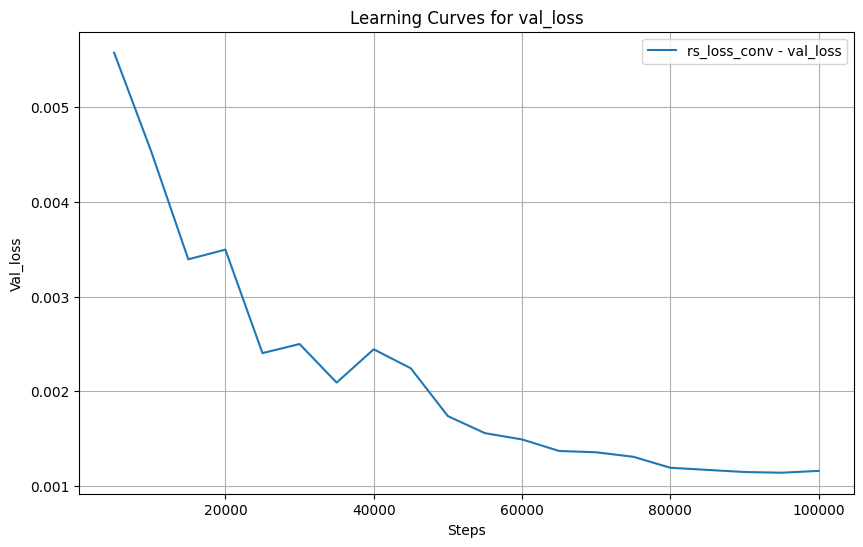

In [6]:
# plot learning curves
from vizualization_utils import plot_learning_curves

log_directory = './logs/rs_conv_loss'
subdirs = [run_name]
plot_learning_curves(log_directory, subdirs, metric='val_loss', filename=f'src/figures/{run_name}')
